# QBIO 460 Final Project (PCA model)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read in single cell RNA seq data

In [2]:
# load true labels of cells generated from Seurat package
label_data = pd.read_csv("/Users/zhudifei/Desktop/qbio460_final_project/cell_labels.csv")
print(label_data)

                    Cell  Cluster
0     AAACCCATCATCGCAA-1        3
1     AAACGCTGTAATCAAG-1        0
2     AAAGAACCACAAGTGG-1        0
3     AAAGAACCATGAATCC-1        0
4     AAAGAACTCCACATAG-1        0
...                  ...      ...
1995  TTTGGAGGTCGGCTAC-1        0
1996  TTTGGTTGTCCTTTGC-1        0
1997  TTTGGTTTCATATGGC-1        0
1998  TTTGTTGTCACTGTTT-1        4
1999  TTTGTTGTCGCCGAAC-1        0

[2000 rows x 2 columns]


In [3]:
# load data
file = "/Users/zhudifei/Desktop/qbio460_final_project/subset_calcrpos_matrix.csv"
matrix = pd.read_csv(file, index_col=0)
#print(matrix, matrix.shape)

# transpose data into rows represent cells and columns represent genes
sc_data = matrix.T
print(sc_data)

                    LOC134295191  LOC134295088      ctsh     cd79a  \
AAACCCATCATCGCAA-1     -0.418257     -0.253938 -0.389917 -0.031629   
AAACGCTGTAATCAAG-1     -0.418257     -0.253938 -0.389917 -0.031629   
AAAGAACCACAAGTGG-1     -0.418257     -0.253938 -0.389917 -0.031629   
AAAGAACCATGAATCC-1     -0.418257     -0.253938  2.055642 -0.031629   
AAAGAACTCCACATAG-1     -0.418257     -0.253938 -0.389917 -0.031629   
...                          ...           ...       ...       ...   
TTTGGAGGTCGGCTAC-1     -0.418257     -0.253938 -0.389917 -0.031629   
TTTGGTTGTCCTTTGC-1      2.061663     -0.253938 -0.389917 -0.031629   
TTTGGTTTCATATGGC-1     -0.418257     -0.253938 -0.389917 -0.031629   
TTTGTTGTCACTGTTT-1     -0.418257     -0.253938 -0.389917 -0.031629   
TTTGTTGTCGCCGAAC-1     -0.418257     -0.253938  3.073969 -0.031629   

                    LOC100563644      gng2    vstm2b  LOC100565406  \
AAACCCATCATCGCAA-1     -0.231381 -0.225455 -0.043001     -0.286023   
AAACGCTGTAATCAAG-1 

In [4]:
# check data sparsity
print(sc_data.shape) 

# convert to numeric matrix
numeric_data = sc_data.select_dtypes(include=[float, int])  # Select numeric columns only

cell_matrix = numeric_data.to_numpy()
print(cell_matrix, cell_matrix.shape)

total_elements = cell_matrix.size  # Total number of elements in the matrix
zero_count = (cell_matrix == 0).sum()  # Count of zero entries
sparsity = zero_count / total_elements  # Calculate sparsity
print(f"Sparsity: {sparsity:.2%}")

(2000, 2000)
[[-0.4182565  -0.25393796 -0.38991677 ... -0.20669633 -0.07162326
  -0.23076218]
 [-0.4182565  -0.25393796 -0.38991677 ... -0.20669633 -0.07162326
  -0.23076218]
 [-0.4182565  -0.25393796 -0.38991677 ... -0.20669633 -0.07162326
  -0.23076218]
 ...
 [-0.4182565  -0.25393796 -0.38991677 ... -0.20669633 -0.07162326
  -0.23076218]
 [-0.4182565  -0.25393796 -0.38991677 ... -0.20669633 -0.07162326
   1.65584925]
 [-0.4182565  -0.25393796  3.07396877 ... -0.20669633 -0.07162326
  -0.23076218]] (2000, 2000)
Sparsity: 0.00%


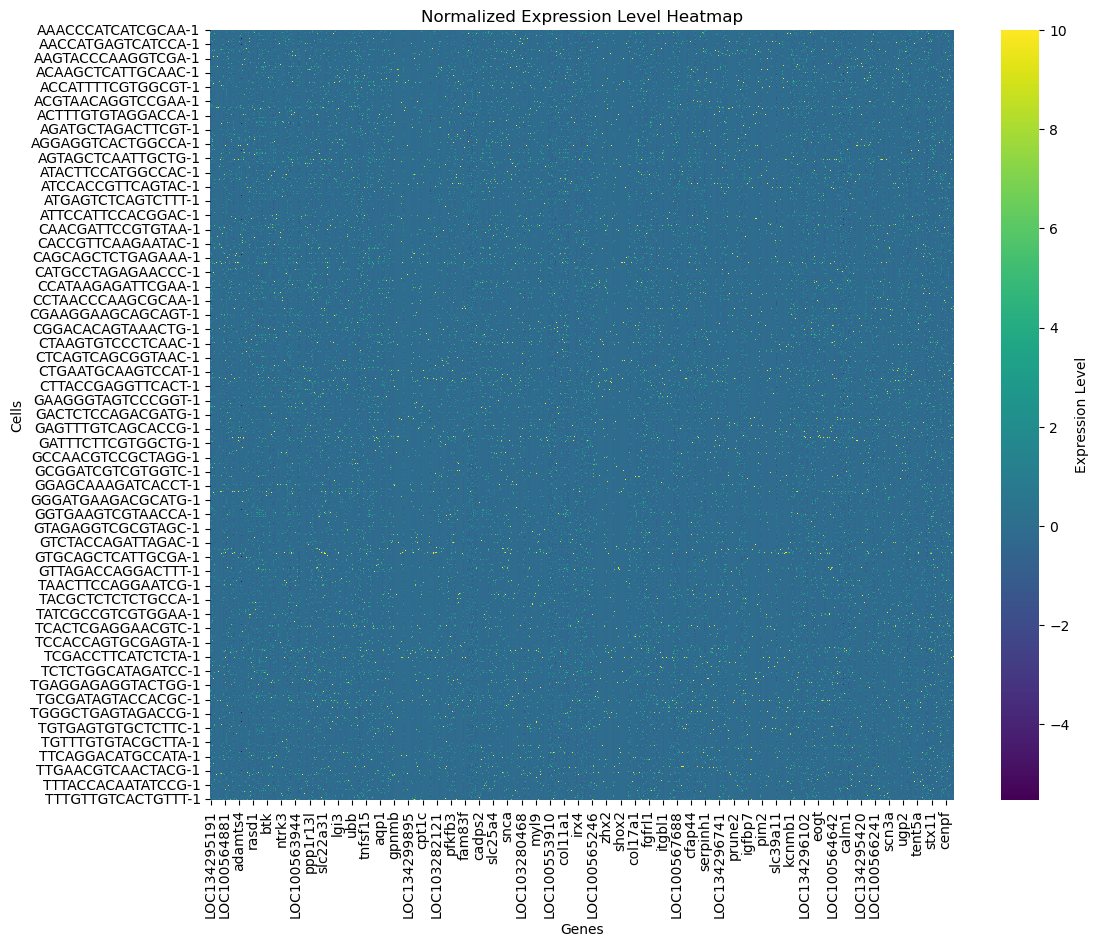

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(sc_data, cmap='viridis', cbar=True, cbar_kws={'label': 'Expression Level'})
plt.title("Normalized Expression Level Heatmap")
plt.xlabel("Genes")
plt.ylabel("Cells")
plt.show()

no zeros after normalizing and scaling, but values are close to zero indicating low gene expression level or noise.

## import and install packages

In [6]:
from sklearn.decomposition import PCA
import umap
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

In [8]:
import time # to track model run time
import tensorflow as tf
import keras
import random

## Set seeds

In [9]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

## Apply PCA dimensional reduction

In [10]:
# PCA model: find number of components
start_pca = time.time()
print(f"start time is: {start_pca}")

pca_model = PCA(n_components=50, random_state=42)
pca_out = pca_model.fit_transform(sc_data)

# record end time
end_pca = time.time()
print(f"end time is: {end_pca}")

duration_pca = end_pca - start_pca
print(f"PCA duration: {duration_pca}")

start time is: 1733942787.668751
end time is: 1733942788.286089
PCA duration: 0.6173379421234131


In [11]:
# analyze explained variance: see how much info is retained with each added component
pca_var = pca_model.explained_variance_ratio_
print(pca_var)

cum_var = pca_var.cumsum()
print(cum_var)

pc_needed = np.argmax(cum_var >= 0.80)
print(f"{pc_needed} components are needed to explain at least 80% of the variance")


# Percentage of variance explained by each component
explained_variance_ratio = pca_var * 100
# Display results
for i, variance in enumerate(explained_variance_ratio, start=1):
    print(f"PC{i}: {variance:.2f}% of variance explained")

[0.05156195 0.0323926  0.02716505 0.02103616 0.02039256 0.01696149
 0.01011081 0.00804801 0.00760735 0.00717053 0.00671752 0.00616248
 0.00565341 0.00552154 0.00523343 0.00479292 0.00464373 0.00441117
 0.00430384 0.004131   0.00371755 0.00351778 0.0034068  0.00314832
 0.00303728 0.00300706 0.00294073 0.00276962 0.00273915 0.00258091
 0.00249246 0.00244489 0.00243397 0.00235358 0.00234024 0.00227673
 0.00225123 0.00222558 0.00218413 0.00216321 0.00214857 0.00211731
 0.00208783 0.00206369 0.0020571  0.00202593 0.00201288 0.00197469
 0.0019459  0.001936  ]
[0.05156195 0.08395454 0.11111959 0.13215575 0.15254831 0.1695098
 0.17962061 0.18766862 0.19527596 0.20244649 0.20916402 0.21532649
 0.2209799  0.22650144 0.23173487 0.23652779 0.24117152 0.24558269
 0.24988653 0.25401753 0.25773508 0.26125286 0.26465966 0.26780798
 0.27084526 0.27385232 0.27679305 0.27956266 0.28230181 0.28488272
 0.28737517 0.28982006 0.29225403 0.2946076  0.29694784 0.29922458
 0.30147581 0.30370139 0.30588552 0.308

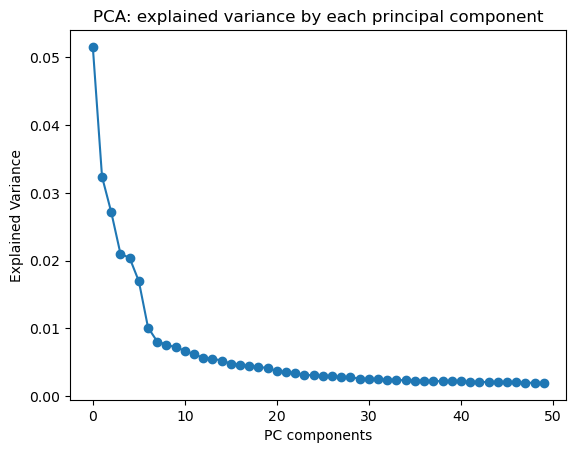

In [12]:
# plot: explained variance by each principal component 
plt.plot(pca_var, marker='o')
plt.title("PCA: explained variance by each principal component")
plt.xlabel("PC components")
plt.ylabel("Explained Variance")
plt.show()

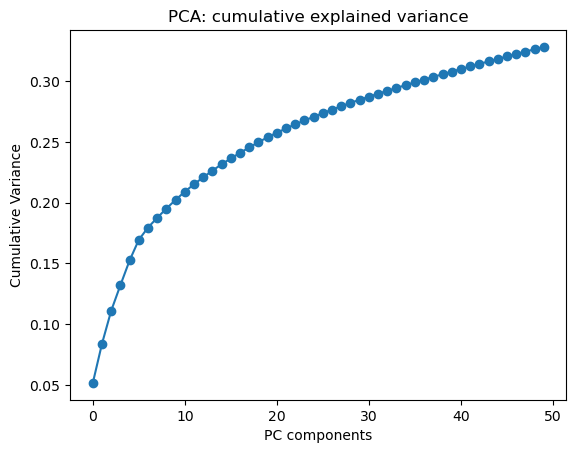

In [13]:
# plot: cumulative variance by each principal component 
plt.plot(cum_var, marker='o')
plt.title("PCA: cumulative explained variance")
plt.xlabel("PC components")
plt.ylabel("Cumulative Variance")
plt.show()

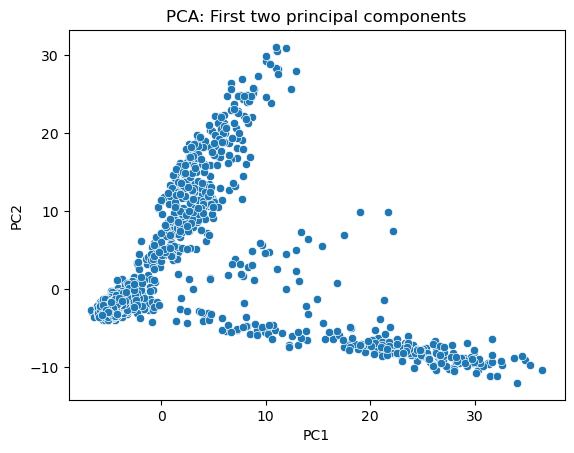

In [14]:
# visualize the first two PC components
# umap
sns.scatterplot(x=pca_out[:, 0], y=pca_out[:, 1])
plt.title("PCA: First two principal components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [15]:
# add true label to visualize PCA
#print(pca_out, pca_out.shape)

# convert to pd dataframe
pca_df = pd.DataFrame(pca_out, columns=[f"PC{i}" for i in range(1,51)])
print(pca_df)

labels_list = (label_data["Cluster"]).tolist()
print(len(labels_list))

pca_df["Labels"] = labels_list
pca_df["Labels"] = pca_df["Labels"].astype(str)
print(pca_df)

           PC1        PC2        PC3       PC4        PC5       PC6       PC7  \
0     4.704185  20.432126 -13.104191 -4.906284  -0.420672 -0.432647  3.793738   
1    -4.648443  -2.771328  -0.923781 -0.502417  -0.337094 -0.154180 -0.396626   
2    -4.418772  -2.016835  -0.808446 -0.634901  -0.153869 -0.157837  1.413111   
3    -5.250470  -1.166475   0.482147  0.250277  -0.144687  1.644496 -2.811891   
4    -4.243931  -3.066853   0.121037 -0.858957   1.208666  0.416615 -2.757172   
...        ...        ...        ...       ...        ...       ...       ...   
1995 -4.275278  -3.125016  -0.596363 -0.112398  -0.991284 -0.794344  4.366155   
1996 -1.951742   1.623517   0.876254  0.940916  -0.731710  5.109880 -0.507661   
1997 -5.076169  -2.965900  -0.326201 -0.804100  -0.757775 -0.636586 -0.813608   
1998  4.569618  21.019558  30.584404 -4.832458 -12.662201 -5.787411 -4.591480   
1999 -5.713105  -3.320485  -1.332529 -0.437671  -0.329204 -0.424591  0.668816   

            PC8       PC9  

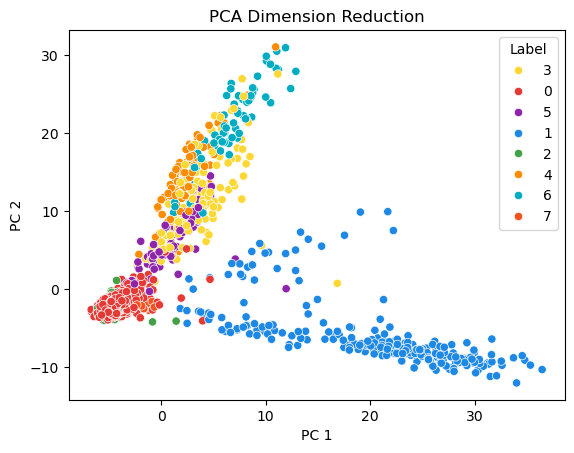

In [16]:
custom_palette = {
    "0": "#E53935",  # Crimson
    "1": "#1E88E5",  # Royal Blue
    "2": "#43A047",  # Forest Green
    "3": "#FDD835",  # Golden Yellow
    "4": "#FB8C00",  # Bright Orange
    "5": "#8E24AA",  # Violet
    "6": "#00ACC1",  # Cerulean
    "7": "#F4511E",  # Vermilion
}

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Labels", palette=custom_palette)
plt.title("PCA Dimension Reduction")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Label")
plt.show()

#### evaluation

In [17]:
pca_2d = pca_df[['PC1', 'PC2']]
print(pca_2d)

# silhouette_score score
pca_sil = silhouette_score(pca_2d, label_data["Cluster"])
print(f"silhouette score for 2D PCA projection: {pca_sil}")

           PC1        PC2
0     4.704185  20.432126
1    -4.648443  -2.771328
2    -4.418772  -2.016835
3    -5.250470  -1.166475
4    -4.243931  -3.066853
...        ...        ...
1995 -4.275278  -3.125016
1996 -1.951742   1.623517
1997 -5.076169  -2.965900
1998  4.569618  21.019558
1999 -5.713105  -3.320485

[2000 rows x 2 columns]
silhouette score for 2D PCA projection: 0.006641758715392357


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


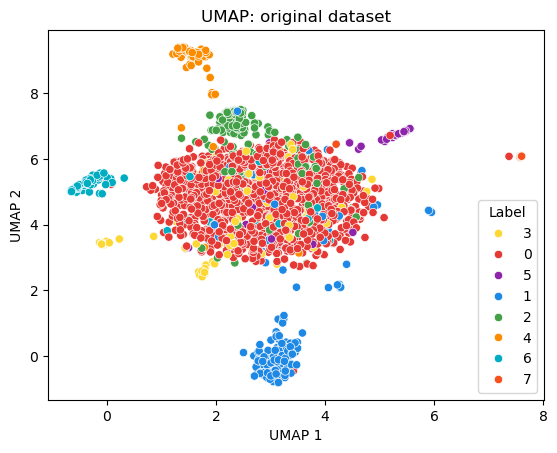

silhouette score for n_neighbors = 15 and min_dist = 0.1: 0.11882773041725159




In [21]:
# apply umap model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(sc_data)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"UMAP{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = labels_list
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Labels", palette=custom_palette)
plt.title(f"UMAP: original dataset")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

umap_sil = silhouette_score(umap_out, label_data["Cluster"])
print(f"silhouette score for n_neighbors = {15} and min_dist = {0.1}: {umap_sil}")
print('\n')

### visualize using UMAP (50 PC)

start analysis for UMAP transformation n_neighbors = 5 and min_dist = 0.1


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 5 and min_dist = 0.1 is: 4.2315850257873535


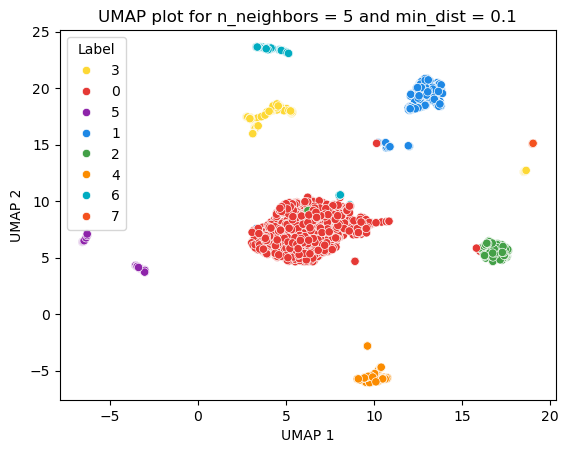

silhouette score for n_neighbors = 5 and min_dist = 0.1: 0.6968442797660828


start analysis for UMAP transformation n_neighbors = 5 and min_dist = 0.5


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 5 and min_dist = 0.5 is: 2.6234021186828613


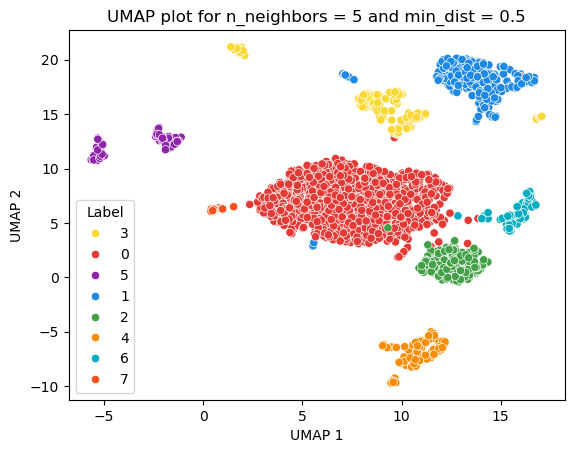

silhouette score for n_neighbors = 5 and min_dist = 0.5: 0.4134035110473633


start analysis for UMAP transformation n_neighbors = 5 and min_dist = 0.9


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 5 and min_dist = 0.9 is: 2.569905996322632


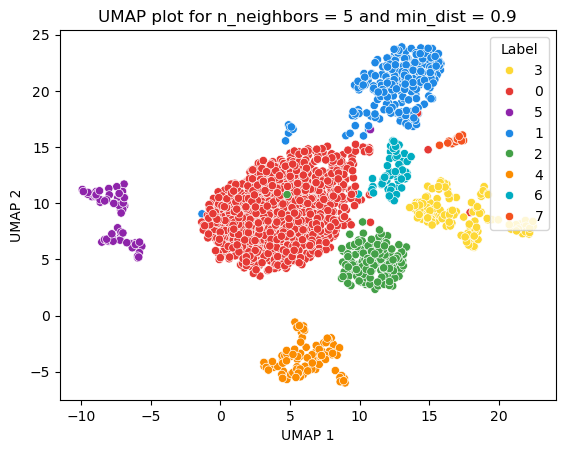

silhouette score for n_neighbors = 5 and min_dist = 0.9: 0.4193451404571533


start analysis for UMAP transformation n_neighbors = 15 and min_dist = 0.1


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 15 and min_dist = 0.1 is: 3.3901331424713135


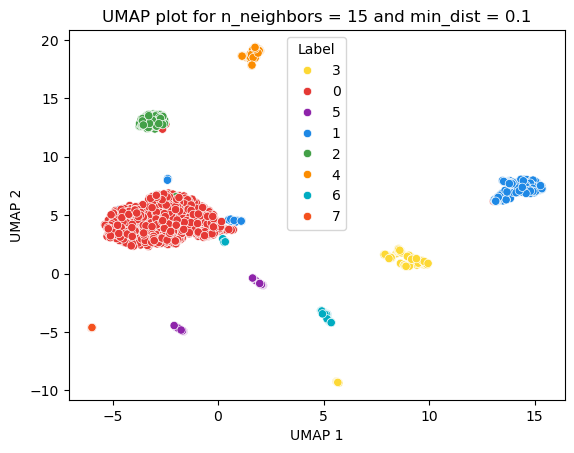

silhouette score for n_neighbors = 15 and min_dist = 0.1: 0.6790260672569275


start analysis for UMAP transformation n_neighbors = 15 and min_dist = 0.5


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 15 and min_dist = 0.5 is: 3.398750066757202


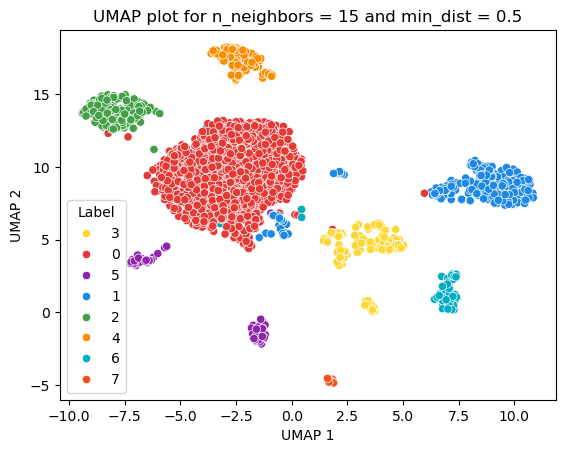

silhouette score for n_neighbors = 15 and min_dist = 0.5: 0.5160543322563171


start analysis for UMAP transformation n_neighbors = 15 and min_dist = 0.9


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 15 and min_dist = 0.9 is: 3.417323112487793


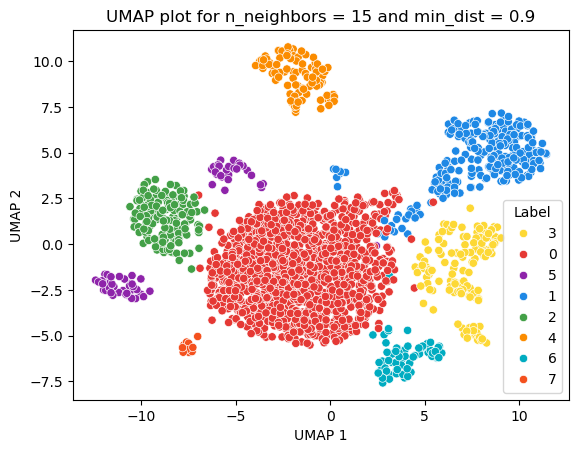

silhouette score for n_neighbors = 15 and min_dist = 0.9: 0.34589460492134094


start analysis for UMAP transformation n_neighbors = 30 and min_dist = 0.1


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 30 and min_dist = 0.1 is: 3.965527057647705


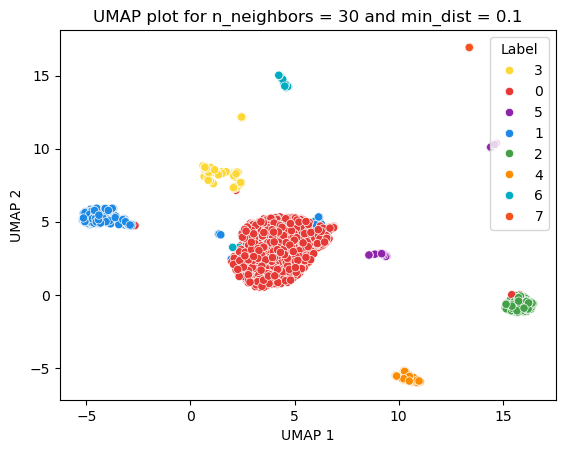

silhouette score for n_neighbors = 30 and min_dist = 0.1: 0.6719483733177185


start analysis for UMAP transformation n_neighbors = 30 and min_dist = 0.5


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 30 and min_dist = 0.5 is: 3.972656011581421


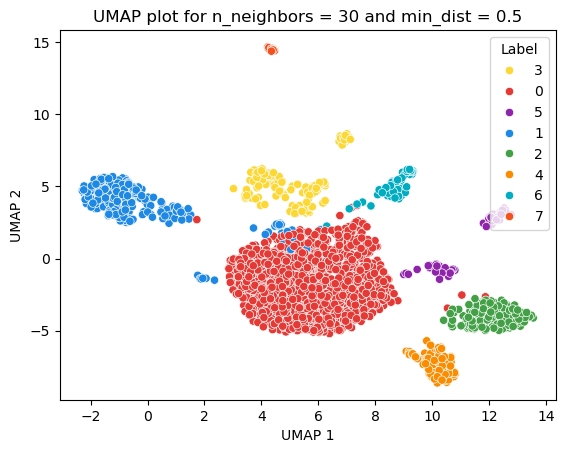

silhouette score for n_neighbors = 30 and min_dist = 0.5: 0.4996928572654724


start analysis for UMAP transformation n_neighbors = 30 and min_dist = 0.9


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 30 and min_dist = 0.9 is: 4.0580267906188965


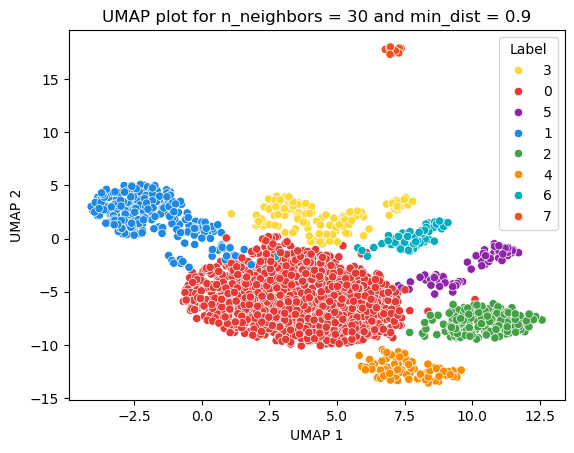

silhouette score for n_neighbors = 30 and min_dist = 0.9: 0.4038284122943878




In [ ]:
n_neighbors = [5, 15, 30]
min_dist = [0.1, 0.5, 0.9]

for n in n_neighbors:
    for m in min_dist:
        
        print(f"start analysis for UMAP transformation n_neighbors = {n} and min_dist = {m}")
        
        # record start time
        start_umap = time.time()
        #print(f"start time for n_neighbors = {n} and min_dist = {m} is: {start_umap}")

        # apply umap model
        umap_model = umap.UMAP(n_neighbors=n, min_dist=m, n_components=2, random_state=42, metric='euclidean')
        umap_out = umap_model.fit_transform(pca_df)

        # record end time
        end_umap = time.time()
        #print(f"end time is: {end_umap}")
        
        duration_umap = end_umap - start_umap
        print(f"umap duration for n_neighbors = {n} and min_dist = {m} is: {duration_umap}")

        # convert end_umap to panda df
        #print(umap_out, umap_out.shape)
        umap_df = pd.DataFrame(umap_out, columns=[f"UMAP{i}" for i in range(1,3)])
        #print(umap_df)

        
        umap_df["Labels"] = labels_list
        umap_df["Labels"] = umap_df["Labels"].astype(str)
        #print(umap_df)

        
        # visualize first two pc components
        sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Labels", palette=custom_palette)
        plt.title(f"UMAP plot for n_neighbors = {n} and min_dist = {m}")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.legend(title="Label")
        plt.show()
        
        # silhouette score
        ## umap_out is a numpy array
        umap_sil = silhouette_score(umap_out, label_data["Cluster"])
        print(f"silhouette score for n_neighbors = {n} and min_dist = {m}: {umap_sil}")
        print('\n')

### visualize using tSNE (50 PC)

In [ ]:
from sklearn.manifold import TSNE

start analysis for tSNE transformation perplexity = 5 and learning rate = 10
tsne duration for perplexity = 5 and learning rate = 10 is: 3.284353017807007


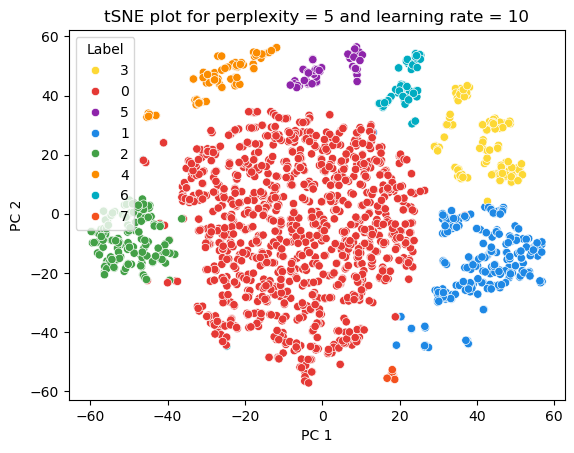

silhouette score for perplexity = 5 and learning rate = 10: 0.16320815682411194


start analysis for tSNE transformation perplexity = 5 and learning rate = 100
tsne duration for perplexity = 5 and learning rate = 100 is: 3.3603482246398926


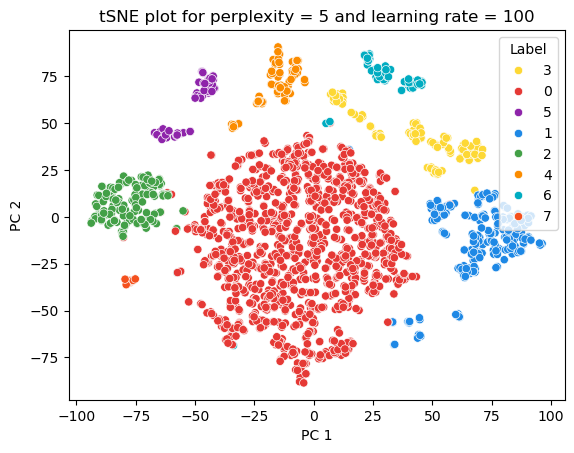

silhouette score for perplexity = 5 and learning rate = 100: 0.2591707408428192


start analysis for tSNE transformation perplexity = 5 and learning rate = 500
tsne duration for perplexity = 5 and learning rate = 500 is: 3.2840888500213623


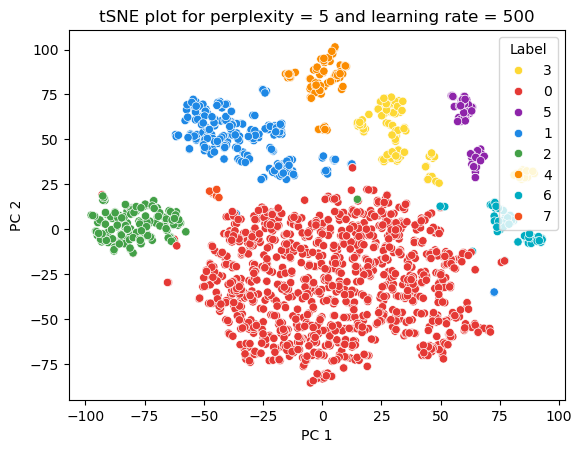

silhouette score for perplexity = 5 and learning rate = 500: 0.21234244108200073


start analysis for tSNE transformation perplexity = 30 and learning rate = 10
tsne duration for perplexity = 30 and learning rate = 10 is: 3.7845618724823


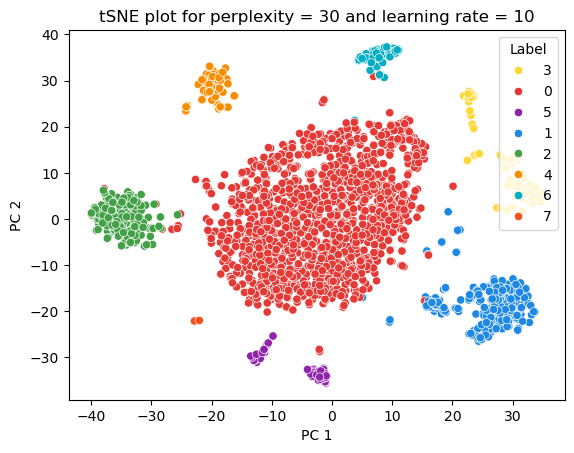

silhouette score for perplexity = 30 and learning rate = 10: 0.3551490902900696


start analysis for tSNE transformation perplexity = 30 and learning rate = 100
tsne duration for perplexity = 30 and learning rate = 100 is: 3.810844898223877


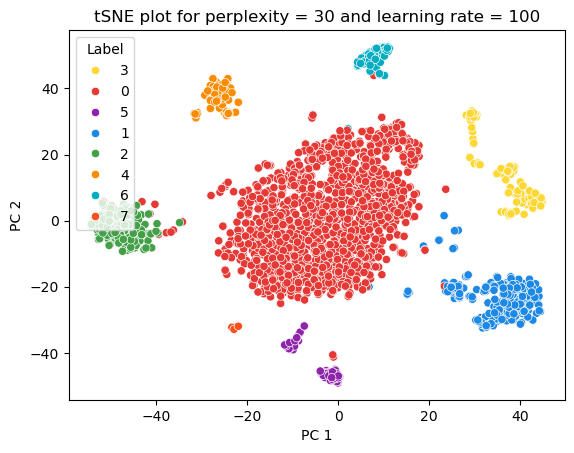

silhouette score for perplexity = 30 and learning rate = 100: 0.3935626447200775


start analysis for tSNE transformation perplexity = 30 and learning rate = 500
tsne duration for perplexity = 30 and learning rate = 500 is: 4.077885866165161


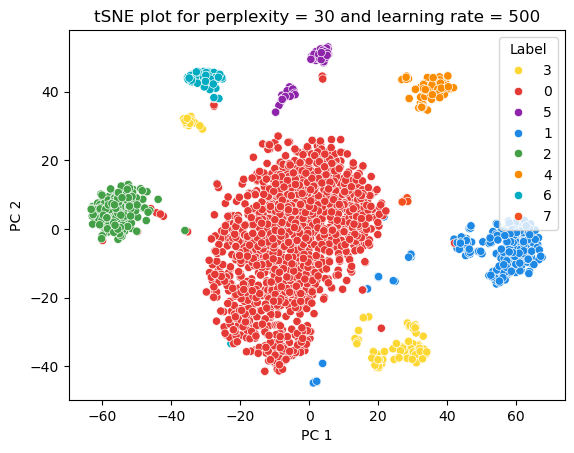

silhouette score for perplexity = 30 and learning rate = 500: 0.327302485704422


start analysis for tSNE transformation perplexity = 50 and learning rate = 10
tsne duration for perplexity = 50 and learning rate = 10 is: 4.308010101318359


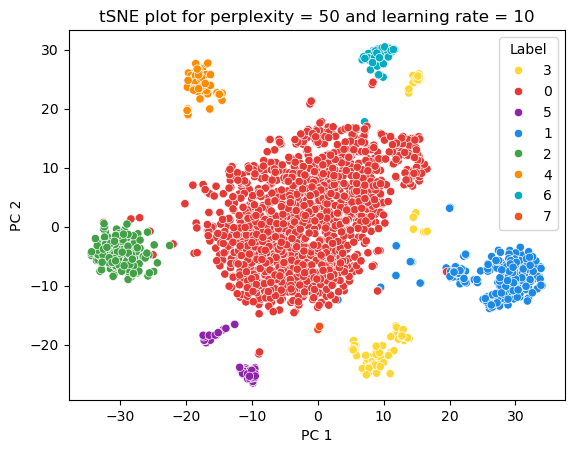

silhouette score for perplexity = 50 and learning rate = 10: 0.2806836664676666


start analysis for tSNE transformation perplexity = 50 and learning rate = 100
tsne duration for perplexity = 50 and learning rate = 100 is: 4.086652040481567


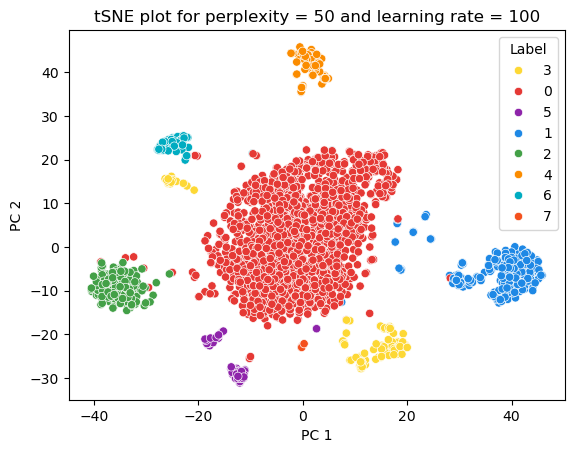

silhouette score for perplexity = 50 and learning rate = 100: 0.3454211950302124


start analysis for tSNE transformation perplexity = 50 and learning rate = 500
tsne duration for perplexity = 50 and learning rate = 500 is: 4.532785892486572


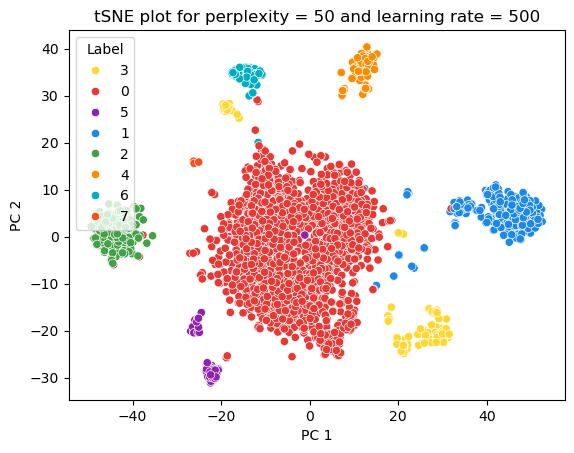

silhouette score for perplexity = 50 and learning rate = 500: 0.38498443365097046




In [ ]:
perplexity = [5, 30, 50]
learning_rate = [10, 100, 500]



for i in perplexity:
    for j in learning_rate:

        print(f"start analysis for tSNE transformation perplexity = {i} and learning rate = {j}")
        # record start time
        start_tsne = time.time()
        #print(f"start time for perplexity = {i} and learning rate = {j} is: {start_tsne}")

        # apply tsne model
        tsne_model = TSNE(n_components=2, learning_rate=j, perplexity=i, random_state=42)
        tsne_out = tsne_model.fit_transform(pca_df)

        # record end time
        end_tsne = time.time()
        #print(f"end time is: {end_tsne}")
        
        duration_tsne = end_tsne - start_tsne
        print(f"tsne duration for perplexity = {i} and learning rate = {j} is: {duration_tsne}")

        # convert tsne_out to panda df
        #print(tsne_out, tsne_out.shape)
        tsne_df = pd.DataFrame(tsne_out, columns=[f"PC{i}" for i in range(1,3)])
        #print(tsne_df)

        tsne_df["Labels"] = labels_list
        tsne_df["Labels"] = tsne_df["Labels"].astype(str)
        #print(tsne_df)

        # visualize first two pc components
        sns.scatterplot(data=tsne_df, x="PC1", y="PC2", hue="Labels", palette=custom_palette)
        plt.title(f"tSNE plot for perplexity = {i} and learning rate = {j}")
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.legend(title="Label")
        plt.show()
        
        # silhouette_score score
        ## tsne_out is a numpy array
        tsne_sil = silhouette_score(tsne_out, label_data["Cluster"])
        print(f"silhouette score for perplexity = {i} and learning rate = {j}: {tsne_sil}")
        print('\n')

### perform hierarchical clustering based on PCA

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

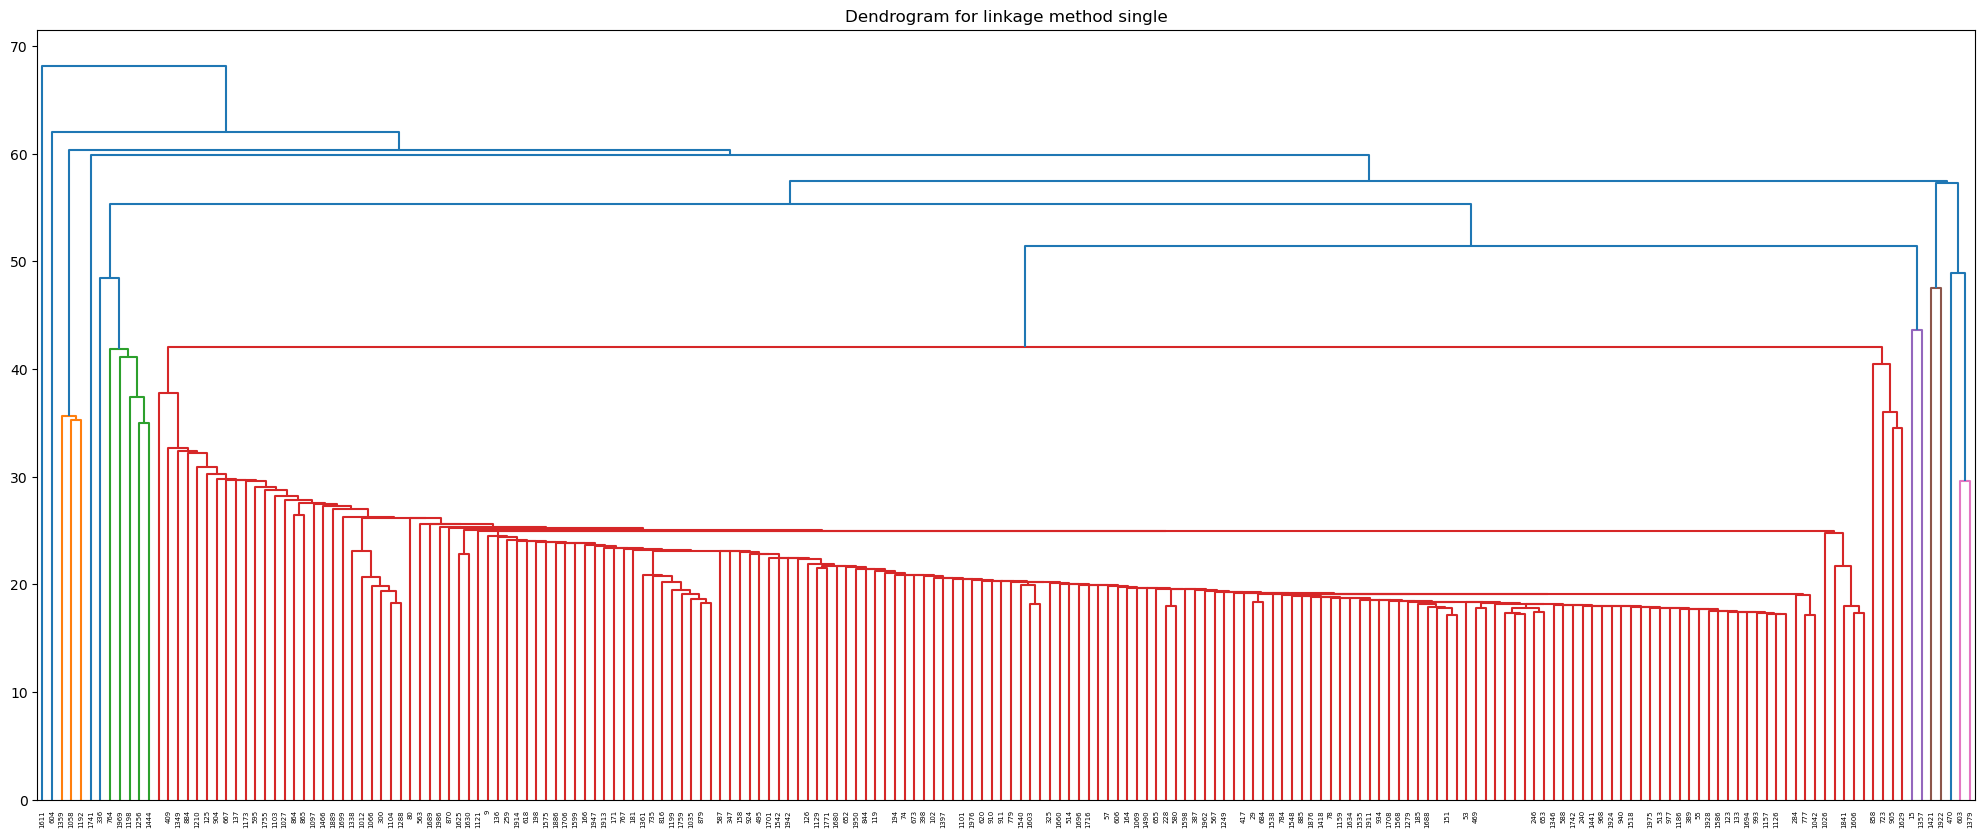

Clusters for linkage method single: [3 3 3 ... 3 3 3]


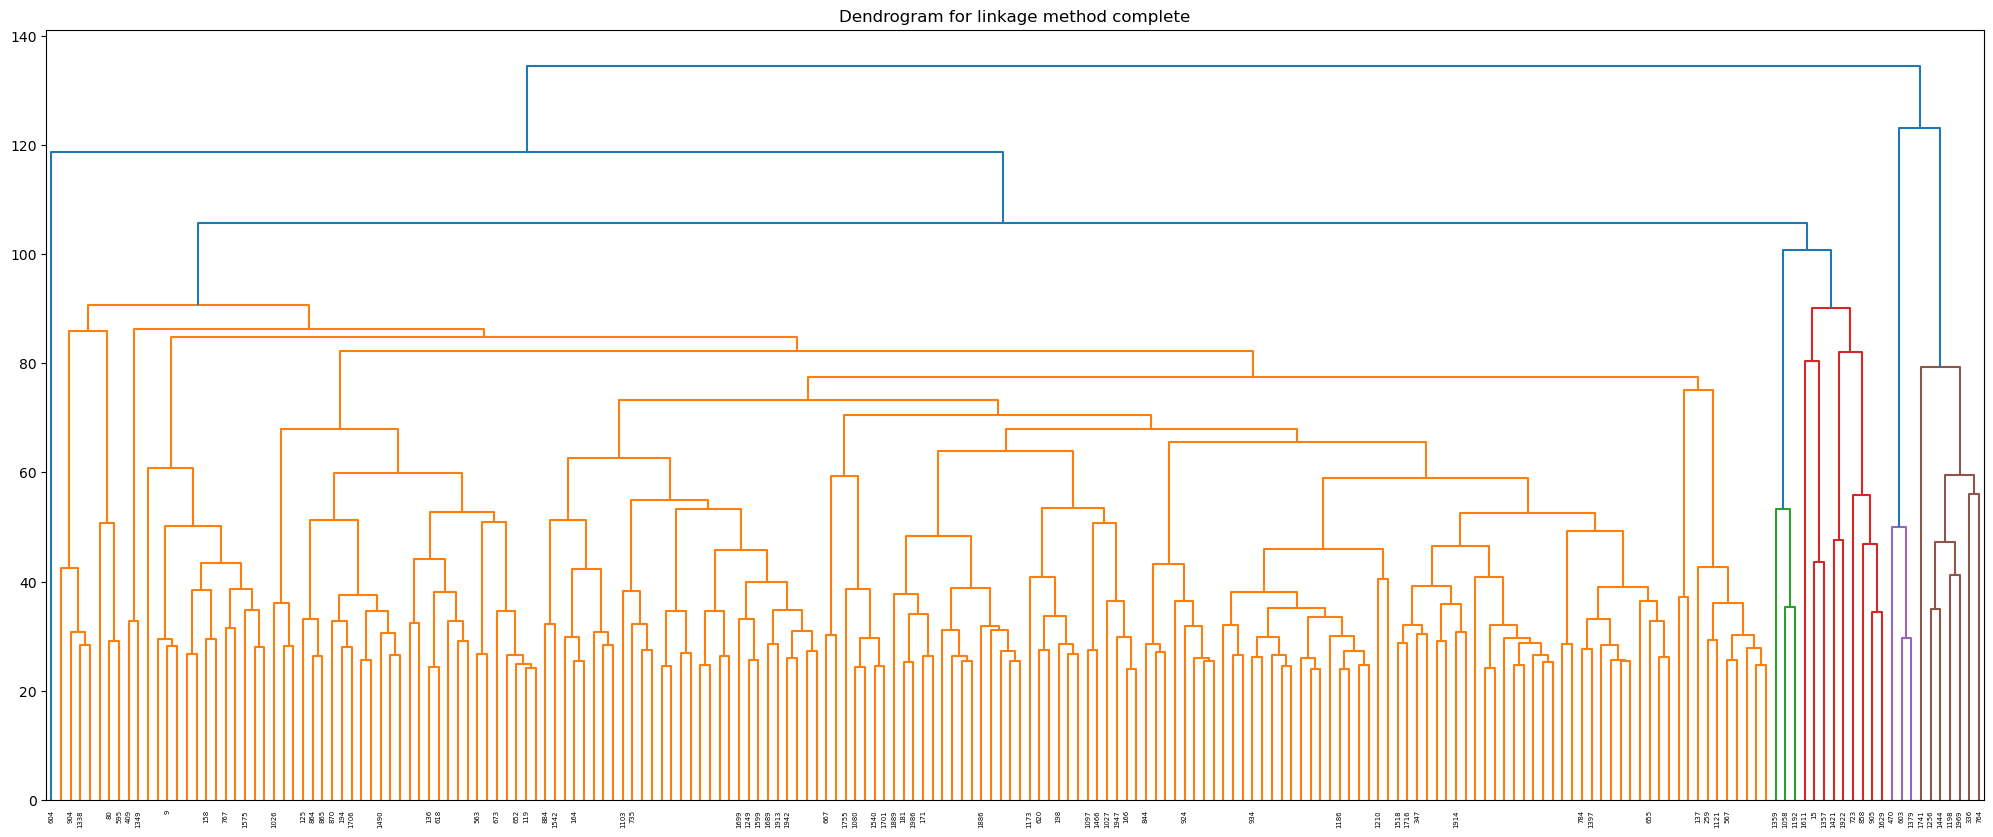

Clusters for linkage method complete: [2 2 2 ... 2 2 2]


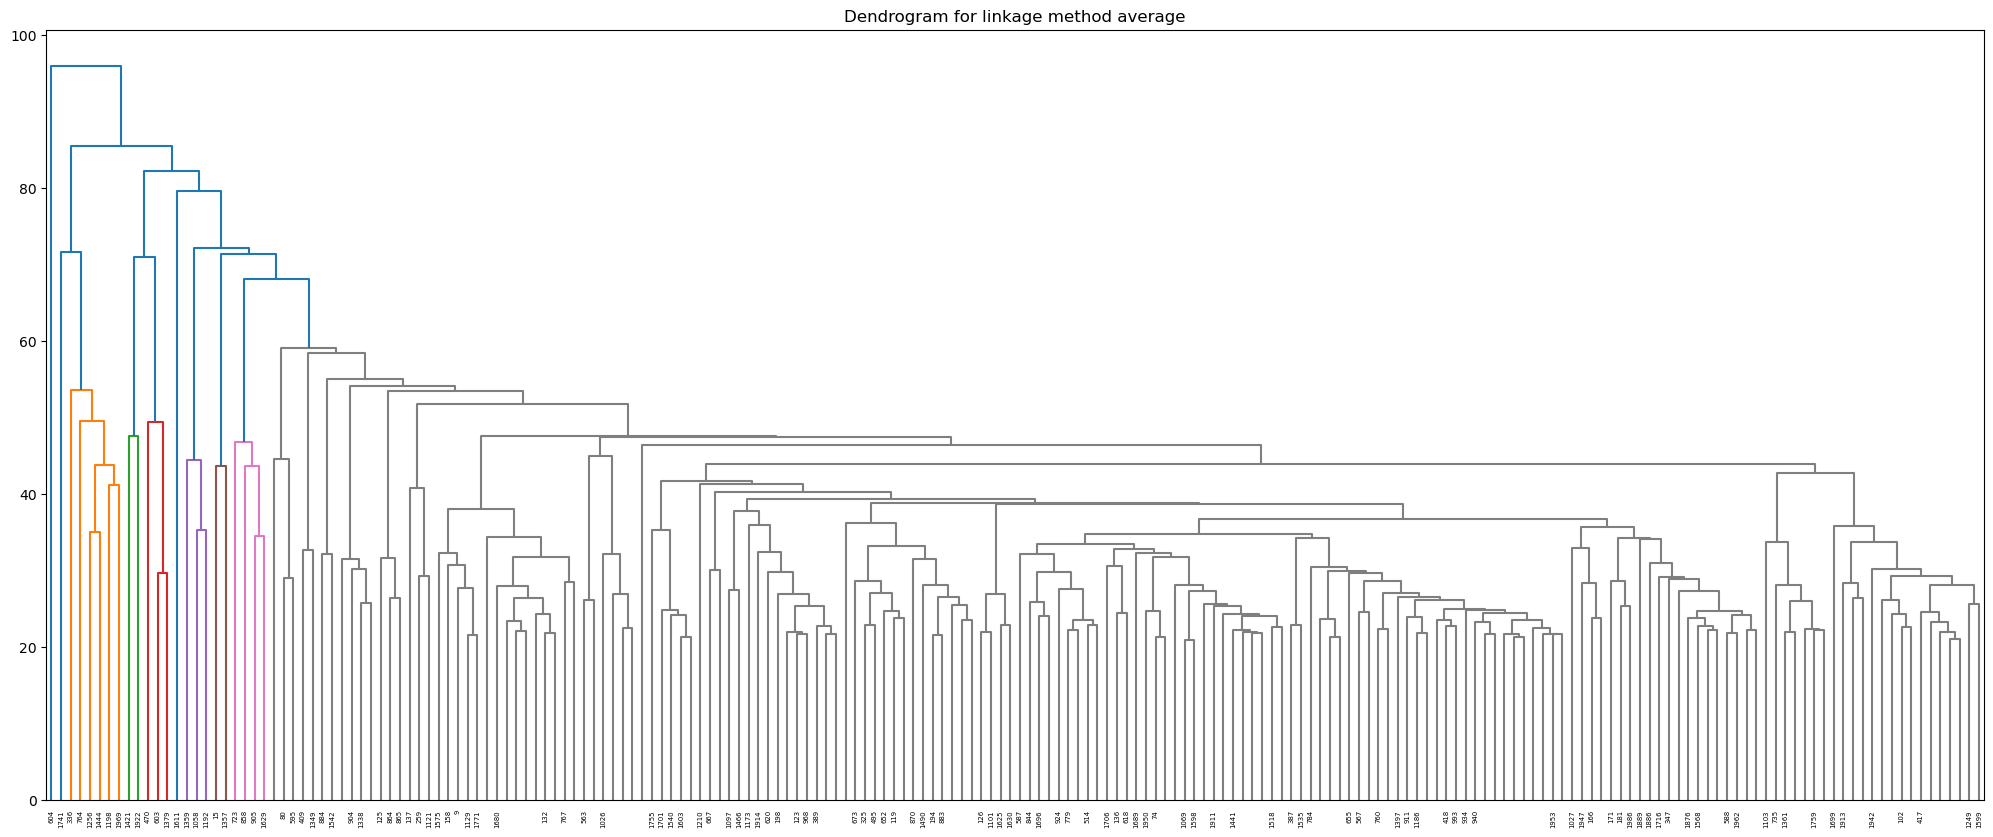

Clusters for linkage method average: [8 8 8 ... 8 8 8]


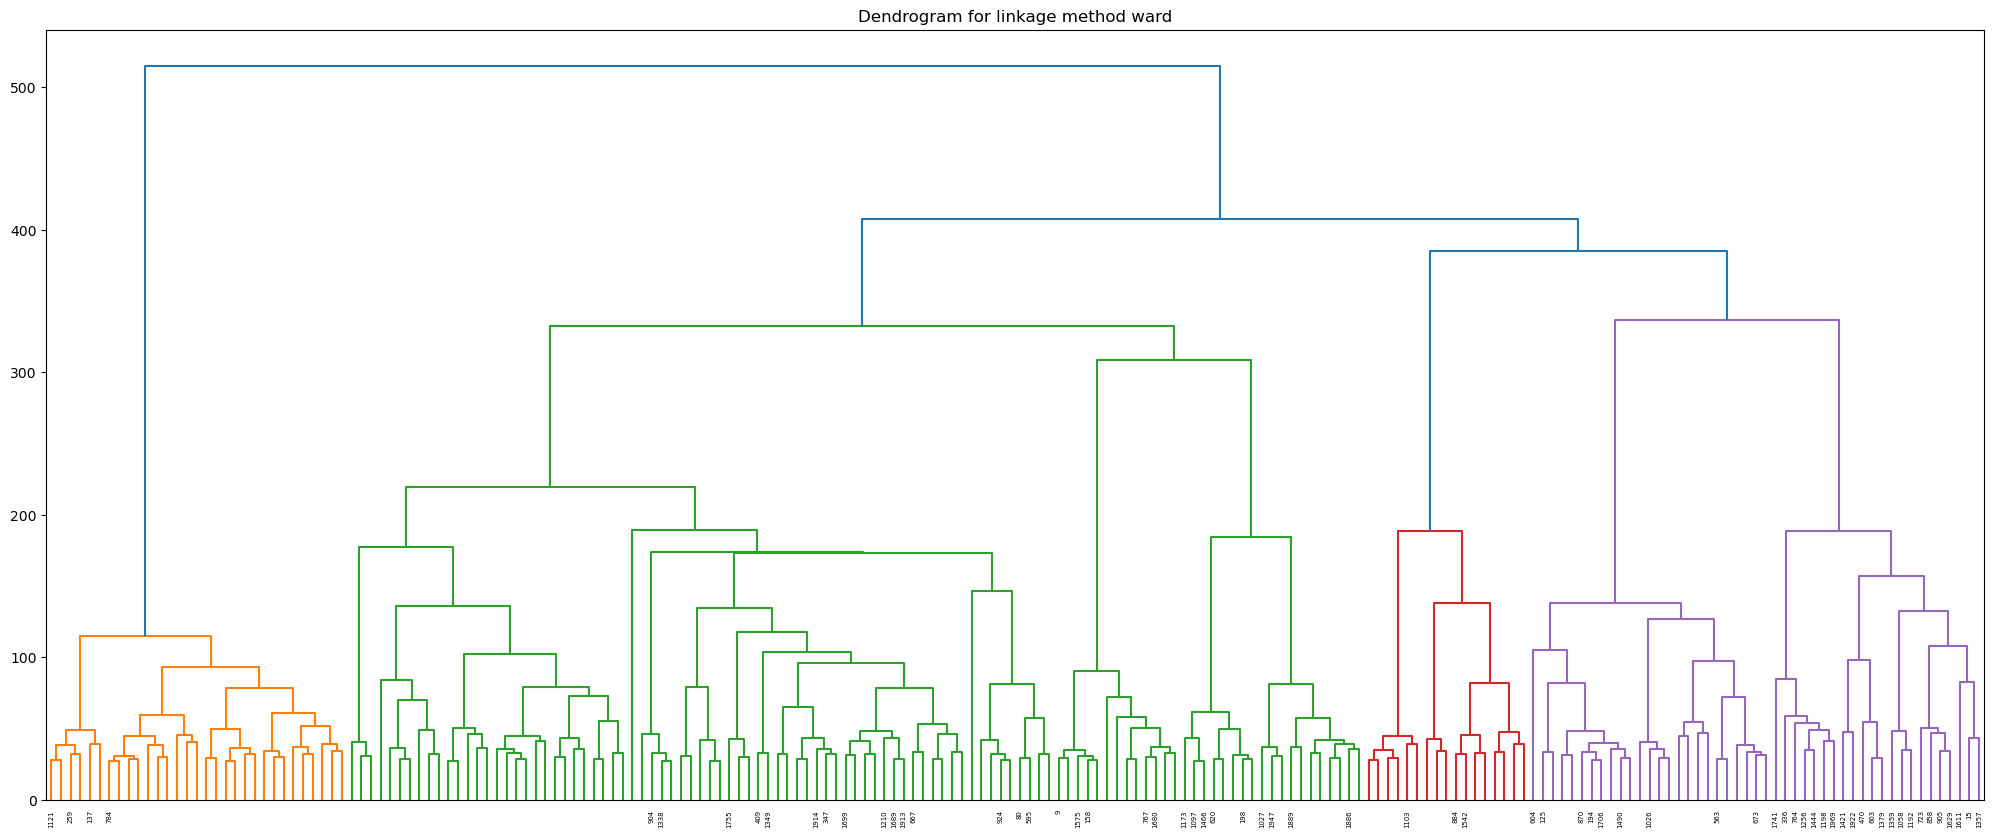

Clusters for linkage method ward: [5 2 2 ... 2 6 2]


In [ ]:
linkages = ['single','complete', 'average', 'ward']


for l in linkages:
    hier_model = linkage(pca_df, method=l)
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(hier_model, truncate_mode='lastp', p=200, show_leaf_counts=False)
    plt.title(f"Dendrogram for linkage method {l}")
    plt.show()
    
    
    # cut the dendrogram
    if l == 'single':
        single_clusters = fcluster(hier_model, t=50, criterion='distance')
        print(f"Clusters for linkage method {l}:", single_clusters)
    elif l == 'complete':
        complete_clusters = fcluster(hier_model, t=90, criterion='distance')
        print(f"Clusters for linkage method {l}:", complete_clusters)
    elif l == 'average':
        average_clusters = fcluster(hier_model, t=60, criterion='distance')
        print(f"Clusters for linkage method {l}:", average_clusters)
    elif l == 'ward':
        ward_clusters = fcluster(hier_model, t=300, criterion='distance')
        print(f"Clusters for linkage method {l}:", ward_clusters)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
# flatten selected_label
label_data["Cluster"]
print((label_data["Cluster"]))

0       3
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    0
1998    4
1999    0
Name: Cluster, Length: 2000, dtype: int64


In [ ]:

ARI_single = adjusted_rand_score(label_data["Cluster"], single_clusters)
print(f"ARI for single hierarchical: {ARI_single}")

ARI_complete = adjusted_rand_score(label_data["Cluster"], complete_clusters)
print(f"ARI for complete hierarchical: {ARI_complete}")

ARI_average = adjusted_rand_score(label_data["Cluster"], average_clusters)
print(f"ARI for average hierarchical: {ARI_average}")

ARI_ward = adjusted_rand_score(label_data["Cluster"], ward_clusters) # use ward to extract labels
print(f"ARI for ward hierarchical: {ARI_ward}")

ARI for single hierarchical: 0.01630004183951138
ARI for complete hierarchical: 0.03268973961813182
ARI for average hierarchical: 0.020018064409535158
ARI for ward hierarchical: 0.58018749520333


##### visualize the generated labels (hierarchical cluster) using UMAP

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


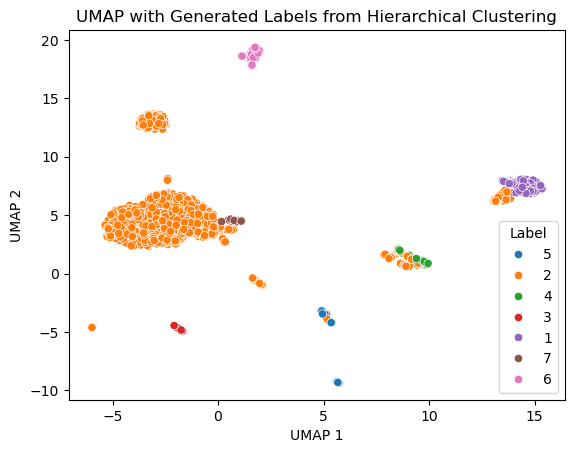

In [ ]:
# apply umap model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(pca_df)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"UMAP{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = ward_clusters
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Labels")
plt.title(f"UMAP with Generated Labels from Hierarchical Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

### perform kmeans clustering based on PCA

In [ ]:
from sklearn.cluster import KMeans

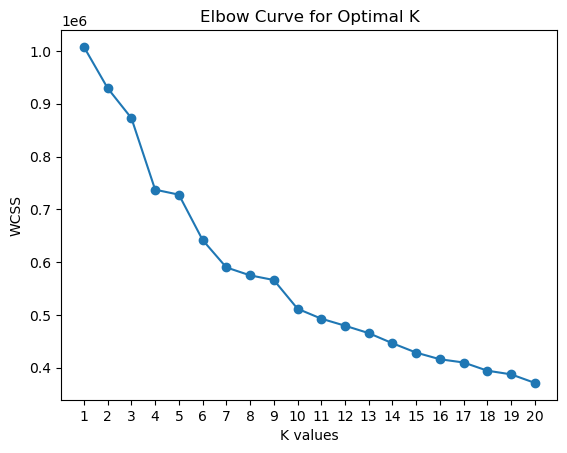

In [ ]:
# elbow method determines K
#selected_subset

# list stores wcss
wcss = []

# a range of k values
k_val = range(1,21)

for k in k_val:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(pca_df)
    wcss.append(model.inertia_)

#print(wcss)

# elbow plot
plt.plot(k_val, wcss, marker='o', linestyle='-')
plt.xlabel('K values')
plt.ylabel('WCSS')
plt.xticks(k_val)
plt.title('Elbow Curve for Optimal K')
plt.show()

In [ ]:
# k means clustering with k=5
KMeans_model = KMeans(n_clusters=10, random_state=42)
KMeans_model.fit(pca_df)

# predicted clusters
predicted_cluster = KMeans_model.labels_
#print(predicted_cluster, predicted_cluster.shape)


In [ ]:
ARI_kmeans_PCA = adjusted_rand_score(label_data["Cluster"], predicted_cluster)
print(ARI_kmeans_PCA)

0.6659562026856763


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


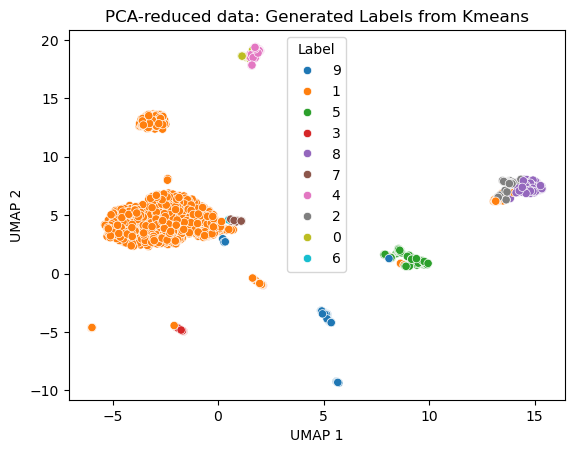

In [ ]:
# apply umap model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(pca_df)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"PC{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = predicted_cluster
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="PC1", y="PC2", hue="Labels")
plt.title(f"PCA-reduced data: Generated Labels from Kmeans")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

### perform GMM clustering based on PCA

In [ ]:
from sklearn.mixture import GaussianMixture

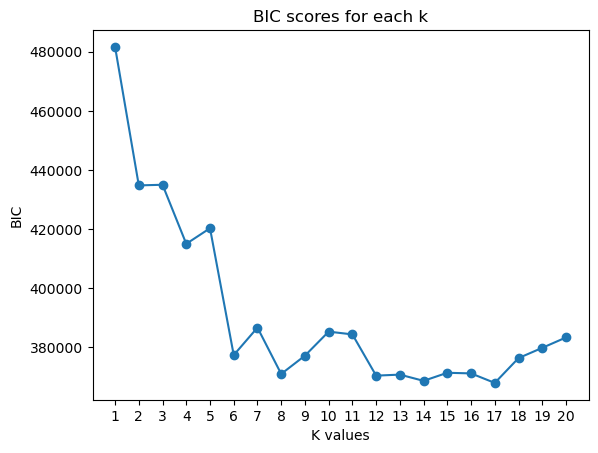

In [ ]:
# k values
k_val

# list stores bic score for each k
bic_score = []

for k1 in k_val:
    model_1 = GaussianMixture(n_components=k1, random_state=42)
    model_1.fit(pca_df)
    bic_score.append(model_1.bic(pca_df))

#print(bic_score)

plt.plot(k_val, bic_score, marker='o', linestyle='-')
plt.xlabel('K values')
plt.ylabel('BIC')
plt.xticks(k_val)
plt.title('BIC scores for each k')
plt.show()

In [ ]:
# k means clustering with k=5
GMM_model = GaussianMixture(n_components=8, random_state=42)
pred_cluster_GMM = GMM_model.fit_predict(pca_df)

# predicted clusters
print(pred_cluster_GMM)

ARI_GMM = adjusted_rand_score(label_data["Cluster"], pred_cluster_GMM)
print(ARI_GMM)


[5 1 1 ... 1 4 1]
0.6913584978747369


##### visualize the generated labels from GMM using UMAP

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


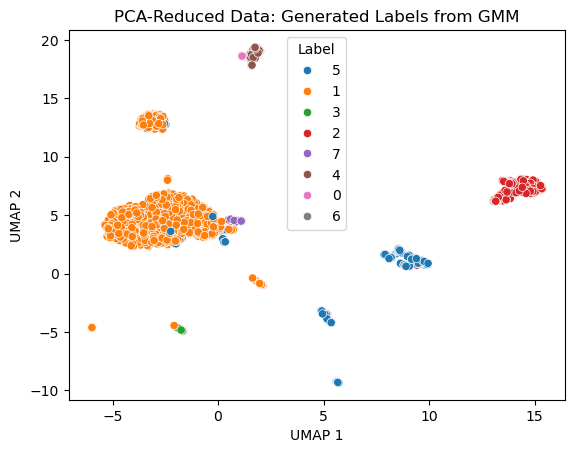

In [ ]:
# apply umap model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(pca_df)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"PC{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = pred_cluster_GMM
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="PC1", y="PC2", hue="Labels")
plt.title(f"PCA-Reduced Data: Generated Labels from GMM")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()


In [ ]:
# silhouette_score score
pca_gmm = silhouette_score(umap_df, pred_cluster_GMM)
print(f"silhouette score for 2D PCA projection: {pca_gmm}")

silhouette score for 2D PCA projection: 0.4548296393003071
